# <center>South African Language Identification</center>


© Explore Data Science Academy

## <center>Introduction</center>

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

The key deliverables in this project include:
* Developing a model that can identify South African languages based on the dataset provided.
* Provide a clear explanation about the performance of the model.
* Analyse the data and generate valuable insights to inform model tuning.
* Provide recommendations based on the performance of classification models applied to the dataset. 

 
## 1. Importing Packages



In [1]:
# Libraries for data loading, data manipulation and data visulisation
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

# Libraries for Data Preprocessing and Modelling
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Set Plot Style
sns.set()
import warnings
warnings.filterwarnings('ignore')

/Users/jack/.pyenv/versions/3.10.2/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 2. Loading Data


The dataset is an aggregation South African official languages, which total about 11. The dataset contains:
* lang-id: Unique String (Language Abbreviation)
* text: Sample texts in different languages.



In [2]:
df_train = pd.read_csv('data/train_set.csv')
df_test = pd.read_csv('data/test_set.csv')
samplesubmission = pd.read_csv('data/sample_submission.csv')

# Preview Train Data
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


Let us look at the bottom rows of the trainn data.

In [3]:
df_train.tail()

,lang_id,text
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999,sot,mafapha a mang le ona a lokela ho etsa ditlale...


In [4]:
# Preview Test Data
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


Check the shapes of the train and test dataset

In [5]:
print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (33000, 2)
Test data shape:  (5682, 2)


In [6]:
print('Dataset size:',df_train.shape)
print('Columns are:',df_train.columns)


Dataset size: (33000, 2)
Columns are: Index(['lang_id', 'text'], dtype='object')


Looking at the number of languages and their frequencies in the train dataset.

In [7]:
df_train['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

The frequency of each of the eleven languages in the dataset is balanced. There are 3000 occurences of each language in the train dataset.
It is pertinent to understand in real life it is natural to deal with imbalanced data in most cases. Therefore, the goal shoudld be on reducing imbalance to manageable levels. It will be interesting to assess the performance of the model when dealing with a balanced daa like the train dataset in this project. 
We can develop a bar chart to confirm the view of how each language occures through the train dataset.

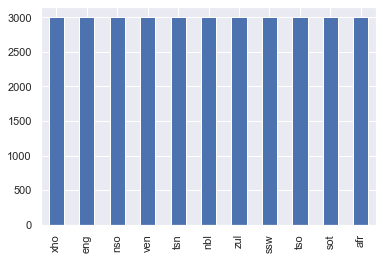

In [8]:
df_train.lang_id.value_counts().plot(kind='bar');

## 3. Data Preprocessing


In preparation for modelling, it is important to ensure the dataset is turned into a formate that makes it easy for the model to make sense of the data. Text cleaning is necesary because it ensures that the text data is free of things like punctuation, numerical values and other signs that do not have a direct impact on the performance of the classification model. They are considered noise, which can ultimately affect the accuracy of the model. The key steps in text cleaning include:
* Removal of special characters
* Removing punctuation
* Lowering the caps

All these steps are carried to make it easy for machine learning models to make sense of the data during analysis. 


In [9]:
# Create function to clean the data

def text_cleaning(df, col):
  """ Takes in a string value, returns string devoid of url, punctuation and caps lower"""

  # Handling URLs
  print ('Removing URLs...')
  pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
  subs_url = r'url-web'
  df[col] = df[col].replace(to_replace = pattern_url, value = subs_url, regex = True)

  # Make lower case
  print ('Lowering case...')
  df[col] = df[col].str.lower()

  # Dealing with Punctuation
  print('Removing punctuation...')
  def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
  df[col] = df[col].apply(remove_punctuation_numbers)
  
  return df


In [10]:
# Create a copy of train and test data 
train_data = df_train.copy()
test_data = df_test.copy()

In [11]:
# Apply Text Preprocessing
train_data = text_cleaning(train_data, 'text')

test_data = text_cleaning(test_data, 'text')

Removing URLs...
Lowering case...
Removing punctuation...
Removing URLs...
Lowering case...
Removing punctuation...


In [12]:
# Preview Cleaned Train Data
train_data.head()

,lang_id,text
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [13]:
# Preview Cleaned Test Data
test_data.head()

,index,text
0,1,mmasepala fa maemo a a kgethegileng a letlelel...
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,tshivhumbeo tshi fana na ngano dza vhathu
3,4,kube inja nelikati betingevakala kutsi titsini...
4,5,winste op buitelandse valuta


## 4. Feature Engineering

### 4.1 Text Vectorization

[Term Frequency Inverse Document Frequency(TF-IDF)](https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558) is an algorithm that the frequency of word in a document and its rareness across the whole corpus of documents. Term Frequency(tf) is focused on how many times a word appears in a particular document Sklearn tf checks the number of times a term 'x' occurs in a document. 
Inverse Document Frequency(idf) measures how rare or common a term is the entire corpus of documents. A word that is frequent in all the documents analyzed has a normalisation approaching zero or 1 if it is not the case. Sklearn uses the formula:
* idf(t) = log e [ (1+n) / ( 1 + df(t) ) ] + 1 (default i:e smooth_idf = True)

    and

* idf(t) = log e [ n / df(t) ] + 1 (when smooth_idf = False)

The Term Frequency-Inverse Document Frequency(tf-idf) of a document is the product of tf and idf. A higher value indicates the term is more relevant in the document. 


In [14]:
vectorizer = TfidfVectorizer(max_features=25000, max_df=0.8)

The next step is to fit all the words on the vectorizer. 

In [15]:
# Vectorize Train Data
train_data_vec = vectorizer.fit_transform(train_data['text']).toarray()

# Create dataframe for training data
train_new = pd.DataFrame(train_data_vec, columns=vectorizer.get_feature_names())

# Print shape of training dataframe
print('Training Data: ', train_new.shape)

# Vectorize test data
test_data_vec = vectorizer.transform(test_data['text']).toarray()

# New Dataframe for test data
test_new = pd.DataFrame(test_data_vec, columns=vectorizer.get_feature_names())

# Print the shape of test data
print('Test Data: ', test_new.shape)


Training Data:  (33000, 25000)
Test Data:  (5682, 25000)


### 4.2. Prepare Data for Training

In this section, we define features(X) and target(Y) for training. Label Encoding is used to transform string language identities into numerical values for the model to understand.

In [16]:
X = train_new
y = train_data['lang_id']

Apply label encoding in the next cell to convert them into numerical values. 

In [17]:
label_encoder = LabelEncoder() 
y_label = label_encoder.fit_transform(y)

Splitting Data into train and test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.1, random_state=0)

## 5. Modelling

The following models will be tried in this section with the hope selecting the best performing model:
* Logistic Regression
* Passive Aggressive Classifier
* XGBoost Classifier
* Random Forest Classifier
* Ada Boost Classifier
* K NearestNeighbors(KNN)


### 5.1. Build Classification Models

The modelling process is time intensive and demands a lot of computing power. In this section, I will use a limited number of features to assess the performance of pre-selected models before selecting one model for hyperparameter tuning. 

In [21]:
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Passive', 'Random Forest',  'AdaBoost']

In [22]:
classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(3),
    PassiveAggressiveClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier()
]

In [23]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='macro')
    recall    = metrics.recall_score(y_train, y_pred, average='macro')
    
    f1        = metrics.f1_score(y_train, y_pred, average='macro')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average='macro')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 
                                         'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Passive model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring
... All done!


In [24]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
Passive,0.998418,0.998416,0.998409,0.998410,0.986752,39.039785
Logistic Regression,0.994478,0.994459,0.994455,0.994456,0.990633,104.449061
Nearest Neighbors,0.630774,0.908915,0.631010,0.694022,0.518020,0.166127
AdaBoost,0.639731,0.642140,0.638903,0.577411,0.579995,350.856280
Random Forest,0.251953,0.692078,0.252218,0.255053,0.252254,0.791877


<AxesSubplot:xlabel='Classifier'>

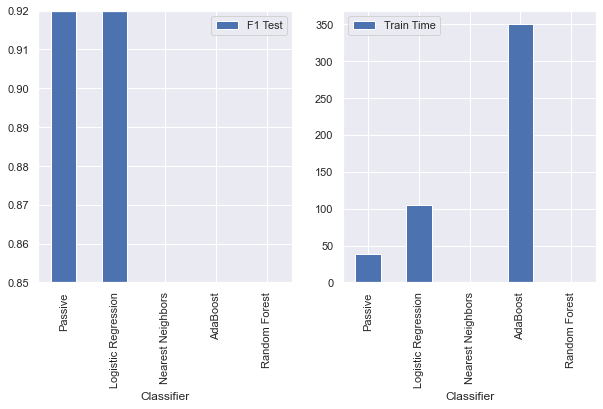

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.85,0.92])
results.plot(y='Train Time', kind='bar', ax=ax[1])

The best performing models the graph are Logistic Regression and Passive Aggressive Classifier. Both models scored 0.87 and 0.92 respectively on the leaderboard. In terms of training time, KNN and Random Forest takes the lowest time to train. AdaBoost takes the longest .



### 5.2. Logistic Regression

In [26]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      1.00       272
           2       0.98      0.98      0.98       312
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       299
           5       0.99      0.99      0.99       320
           6       1.00      1.00      1.00       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       0.98      0.97      0.98       308
          10       0.95      0.96      0.96       312

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



### 5.3. Passive Aggressive Classifier

In [27]:
pa_clf = PassiveAggressiveClassifier(max_iter=50, n_jobs=-1)
pa_clf.fit(X_train, y_train)
pa_clf_pred = pa_clf.predict(X_test)
print(classification_report(y_test, pa_clf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       0.99      1.00      1.00       272
           2       0.99      0.96      0.98       312
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       299
           5       0.97      0.99      0.98       320
           6       1.00      1.00      1.00       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       0.96      0.97      0.96       308
          10       0.96      0.93      0.94       312

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



### 5.4. XGBoost Classifier

In [ ]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', verbosity='2', num_class=11)

In [ ]:
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, xgb_pred))

An accuracy of 0.98 when using 1,500 features on the vectorizer.Overfitting is a possibility in this case. It might come clear when tested on the test dataset. The score on the leaderboard gave 0.76, which confirms that model is overfitting on the validation data. 
Interestingly, the outcome for the validation data when using 1500 features is similar for XGBclassifier, Logistic Regression and Passive Aggressive Classifier. It is possible to increase the accuracy of the model and handle overfitting by tuning some of the parameters.

### 5.5. Naive Bayes

In [19]:
NB = MultinomialNB()

In [21]:
NB.fit(X_train, y_train)
NB_pred= NB.predict(X_test)
print(classification_report(y_test, NB_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      0.99       272
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       299
           5       1.00      1.00      1.00       320
           6       1.00      1.00      1.00       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       1.00      1.00      1.00       308
          10       1.00      0.99      1.00       312

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Presenting the model with the unseen data (the test dataset)

In [22]:
sub_pred = NB.predict(test_new)

### 5.5. Submission File

In [23]:
samplesubmission.head()
submission = pd.DataFrame()
submission['index'] = test_data['index']
submission['lang_id'] = label_encoder.inverse_transform(sub_pred)
submission.to_csv('submission.csv', index=False)

## 6. Conclusion and Recommendations

The two notable models in all the models tried are Logistic Regression and Passive Aggressive Classifier. Logistic Regression overfitted for the validation data but gave a score of 0.87 on the leaderboard. Passive Aggressive Classifier overfitted on the validation data and gave a score of 0.92 on the leaderboard. The XGBoost Classifier running time scales with the number of classes, which explains why it has run the longest in all the models tried for this challenge. 

I would recommend the application of passive aggressive classifier when dealing with a high number of features if time is limited. 
